Loaded shapes:
 - logs: (13995, 8)
 - grades: (233, 6)
 - sim (train_data): (800, 24)

Candidate columns to compare: ['mean_module_grade', 'total_events', 'course_module', 'viewed', 'attempt', 'submitted', 'reviewed', 'course_module_viewed', 'module_count', 'downloaded', 'grade', 'completed']



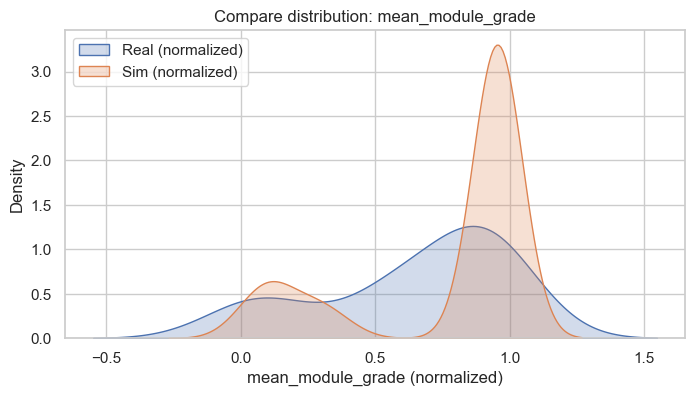

Column: mean_module_grade | KS-stat=0.5326, KS-p=0.0000 | JS-dist(sqrt)=0.6210, JS-div=0.3856


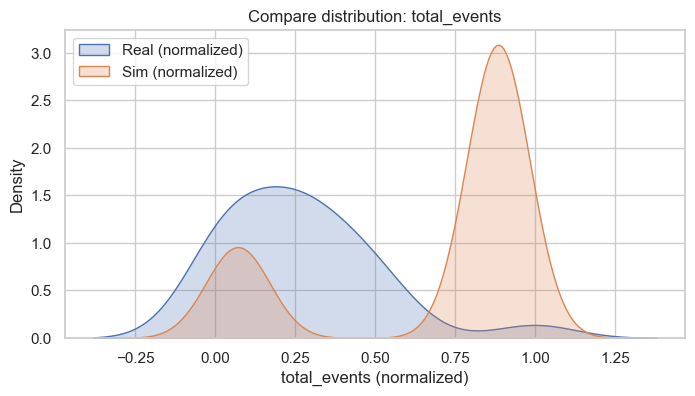

Column: total_events | KS-stat=0.7190, KS-p=0.0000 | JS-dist(sqrt)=0.7313, JS-div=0.5348


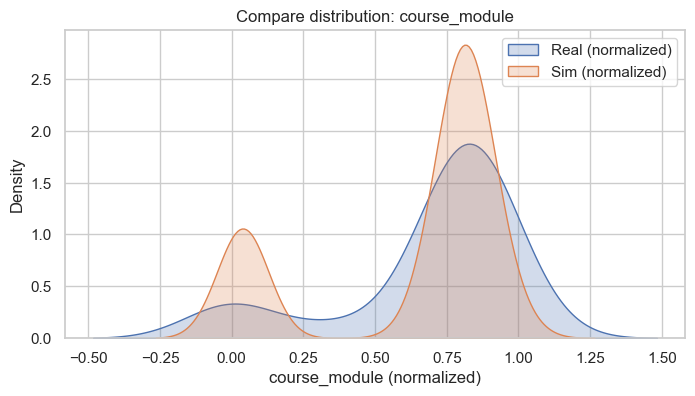

Column: course_module | KS-stat=0.1908, KS-p=0.3445 | JS-dist(sqrt)=0.4372, JS-div=0.1911


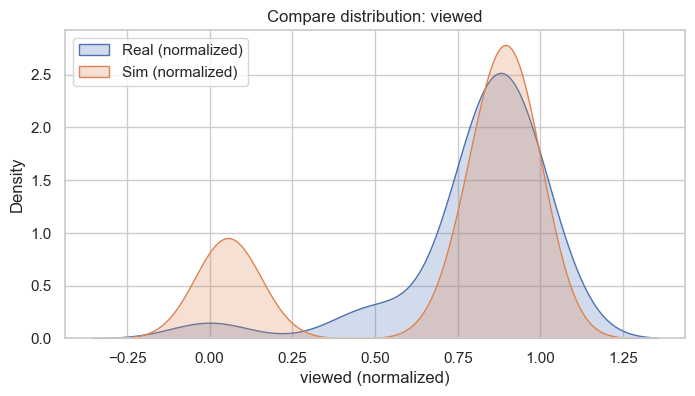

Column: viewed | KS-stat=0.1940, KS-p=0.3250 | JS-dist(sqrt)=0.4742, JS-div=0.2249


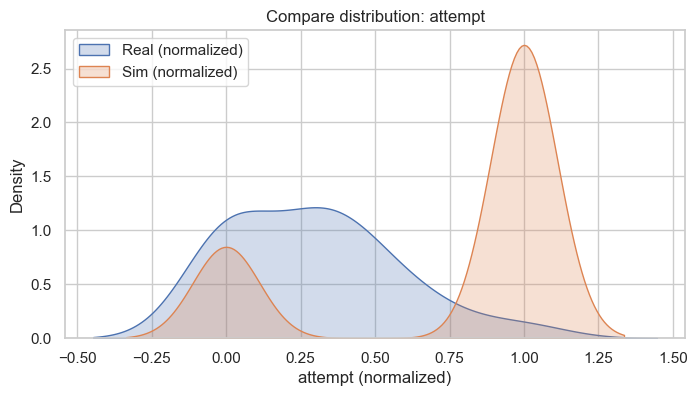

Column: attempt | KS-stat=0.7190, KS-p=0.0000 | JS-dist(sqrt)=0.6410, JS-div=0.4109


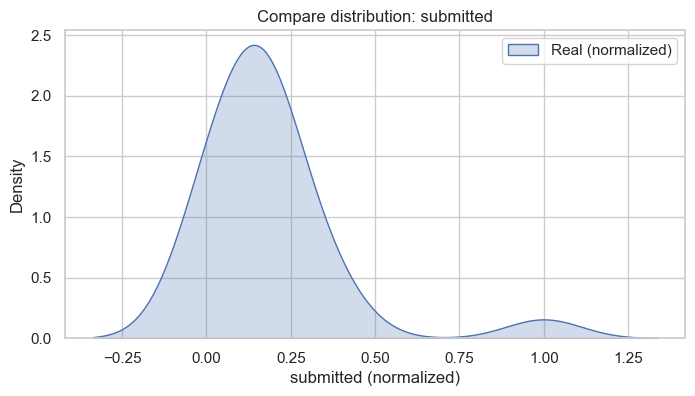

Column: submitted | KS-stat=0.7826, KS-p=0.0000 | JS-dist(sqrt)=0.6384, JS-div=0.4075


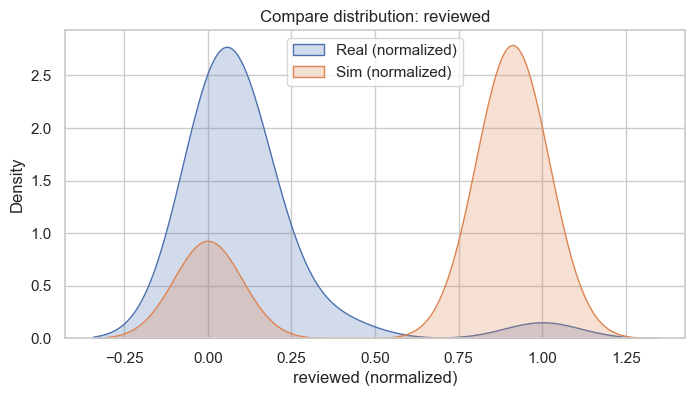

Column: reviewed | KS-stat=0.7190, KS-p=0.0000 | JS-dist(sqrt)=0.6799, JS-div=0.4623


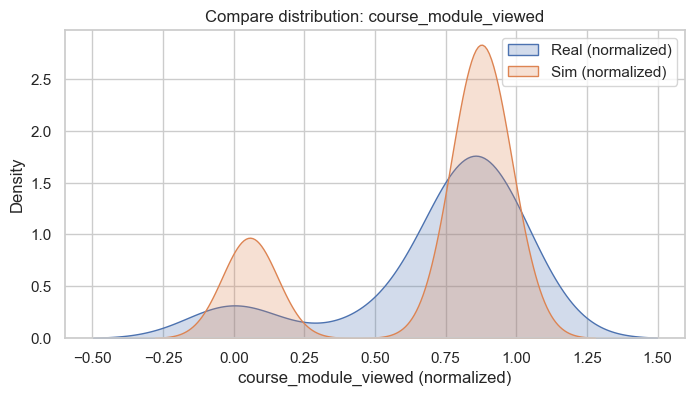

Column: course_module_viewed | KS-stat=0.1842, KS-p=0.3855 | JS-dist(sqrt)=0.5031, JS-div=0.2531


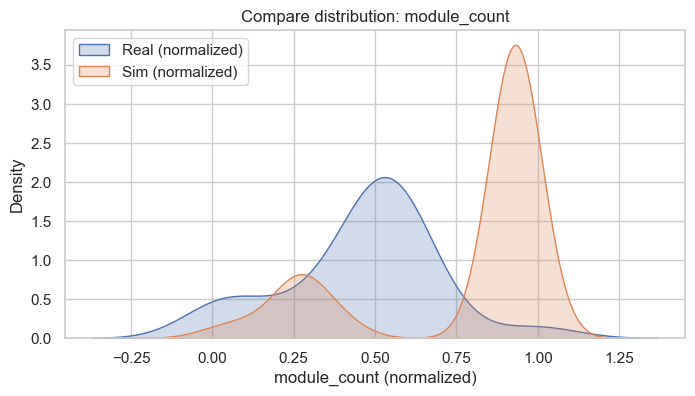

Column: module_count | KS-stat=0.7190, KS-p=0.0000 | JS-dist(sqrt)=0.7960, JS-div=0.6337


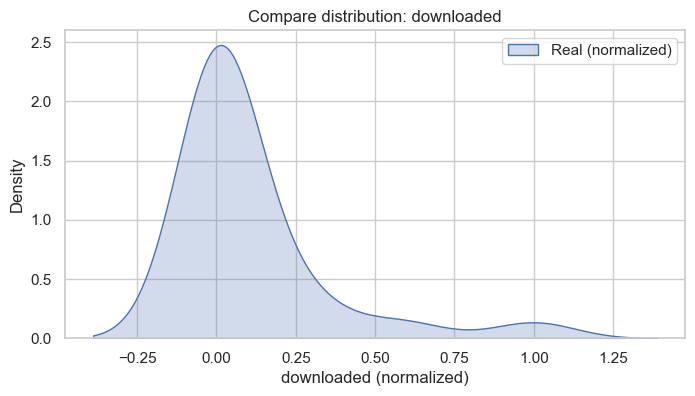

Column: downloaded | KS-stat=0.3043, KS-p=0.0246 | JS-dist(sqrt)=0.3453, JS-div=0.1192


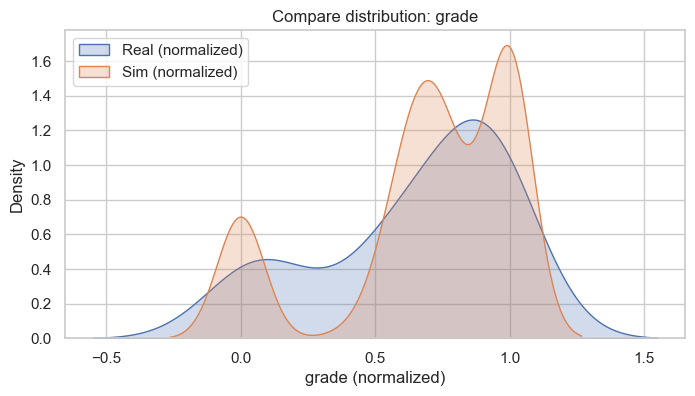

Column: grade | KS-stat=0.2990, KS-p=0.0286 | JS-dist(sqrt)=0.5663, JS-div=0.3208


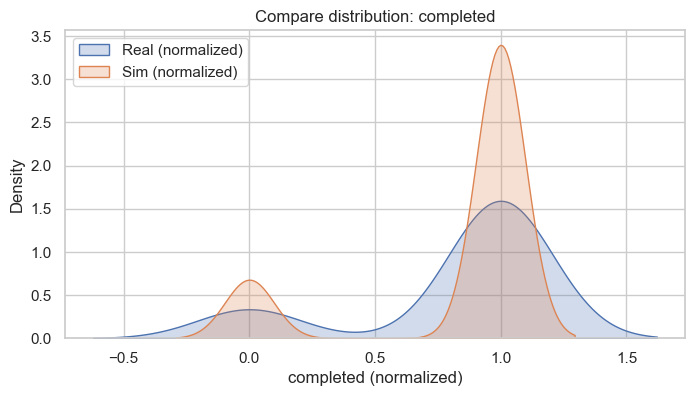

Column: completed | KS-stat=0.0077, KS-p=1.0000 | JS-dist(sqrt)=0.0072, JS-div=0.0001

Summary:


,column,ks_stat,ks_p,js_sqrt,js_divergence,n_real,n_sim
0,module_count,0.719022,3.641353e-12,0.796048,0.633692,23,800
1,total_events,0.719022,3.641353e-12,0.731333,0.534848,23,800
2,reviewed,0.719022,3.641353e-12,0.679890,0.462251,23,800
3,attempt,0.719022,3.641353e-12,0.641017,0.410903,23,800
4,submitted,0.782609,6.552530e-15,0.638385,0.407535,23,800
5,mean_module_grade,0.532609,1.943781e-06,0.620970,0.385603,23,800
6,grade,0.299022,2.862872e-02,0.566349,0.320751,23,800
7,course_module_viewed,0.184239,3.855402e-01,0.503136,0.253146,23,800
8,viewed,0.194022,3.249836e-01,0.474231,0.224895,23,800
9,course_module,0.190761,3.444541e-01,0.437204,0.191148,23,800



Real: correlation(total_events, mean_module_grade) = 0.2966
Sim: correlation(total_events, grade) = 0.0692

Done. Gợi ý tiếp theo:
- Nếu bạn muốn mình chuẩn hoá theo cùng 1 quy tắc (vd: min/max từ real dùng để scale tất cả sim), mình sẽ chỉnh code.
- Nếu có cột cụ thể trong sim bạn muốn map chính xác sang real (vd: 'course_module' = prop of target=='course_module'), báo mình tên cột để map chính xác hơn.


In [4]:
# So sánh phân phối giữa real (logs+grades) và simulate (train_data.csv - aggregated per user)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,4)

# ---- Paths (sửa nếu cần) ----
real_logs_path = "../data/udk_moodle_log_course_670.csv"
real_grades_path = "../data/udk_moodle_grades_course_670.csv"
sim_path = "../../demo_pineline/step7_qlearning/data/simulated/train_data.csv"  # đường dẫn bạn gửi

# ---- Read ----
logs = pd.read_csv(real_logs_path)
grades = pd.read_csv(real_grades_path)
sim = pd.read_csv(sim_path)

print("Loaded shapes:")
print(" - logs:", logs.shape)
print(" - grades:", grades.shape)
print(" - sim (train_data):", sim.shape)
print()

# ---- Basic cleaning / ensure userid column names ----
# In sample sim has 'userid' and 'student_id' - prefer 'userid' if exists else use student_id
if "userid" not in sim.columns and "student_id" in sim.columns:
    sim = sim.rename(columns={"student_id":"userid"})
# make userid int for merges
for df in [logs, grades, sim]:
    if "userid" in df.columns:
        df = df
logs["userid"] = logs["userid"].astype(pd.Int64Dtype())
grades["userid"] = grades["userid"].astype(pd.Int64Dtype())
if "userid" in sim.columns:
    try:
        sim["userid"] = sim["userid"].astype(pd.Int64Dtype())
    except:
        pass

# ---- Build aggregated real-user features to match simulated schema as much as possible ----
# features we attempt to create:
# mean_module_grade (from grades.finalgrade)
# total_events (count of events per user)
# course_module (prop of events with target=='course_module')
# viewed, attempt, feedback_viewed, submitted, reviewed, course_module_viewed, downloaded
# module_count (distinct targets/resource ids) -> approximate by distinct 'other' or eventname
# grade (use finalgrade)
# time_spent -> not present in original logs; will be NaN
# completed -> boolean if finalgrade exists and >= pass threshold (we use >=5 or >0 heuristic)

# prepare logs lower-case for matching
logs_cols = logs.columns.str.lower()
logs.columns = logs_cols

# unify column names access
logs_cols = logs.columns

# create action flags by looking at 'action', 'eventname', 'target'
def flag_by_keywords(row, keywords):
    v = ""
    if 'action' in row.index and pd.notna(row['action']):
        v = str(row['action'])
    if 'eventname' in row.index and pd.notna(row['eventname']):
        v = v + " " + str(row['eventname'])
    if 'target' in row.index and pd.notna(row['target']):
        v = v + " " + str(row['target'])
    v = v.lower()
    for kw in keywords:
        if kw in v:
            return 1
    return 0

# Add some helper bool columns to logs
logs = logs.fillna({"action": "", "eventname":"", "target": "", "other": ""})
logs["is_viewed"] = logs.apply(lambda r: flag_by_keywords(r, ["viewed", "view"]), axis=1)
logs["is_attempt"] = logs.apply(lambda r: flag_by_keywords(r, ["attempt", "trying", "attempted"]), axis=1)
logs["is_feedback_viewed"] = logs.apply(lambda r: flag_by_keywords(r, ["feedback", "feedback_viewed"]), axis=1)
logs["is_submitted"] = logs.apply(lambda r: flag_by_keywords(r, ["submitted", "submit"]), axis=1)
logs["is_reviewed"] = logs.apply(lambda r: flag_by_keywords(r, ["reviewed", "review"]), axis=1)
logs["is_course_module_viewed"] = logs.apply(lambda r: 1 if "course_module" in str(r.get("target","")).lower() or "course_module_viewed" in str(r.get("eventname","")).lower() else 0, axis=1)
logs["is_downloaded"] = logs.apply(lambda r: flag_by_keywords(r, ["download", "downloaded"]), axis=1)

# module_count approx: distinct target values per user (best-effort)
logs["target_str"] = logs["target"].astype(str)
user_agg_logs = logs.groupby("userid").agg(
    total_events = ("id","count"),
    course_module_events = ("target_str", lambda s: sum(1 for v in s if v.lower()=="course_module")),
    viewed_events = ("is_viewed", "sum"),
    attempt_events = ("is_attempt", "sum"),
    feedback_viewed_events = ("is_feedback_viewed", "sum"),
    submitted_events = ("is_submitted", "sum"),
    reviewed_events = ("is_reviewed", "sum"),
    course_module_viewed_events = ("is_course_module_viewed", "sum"),
    downloaded_events = ("is_downloaded", "sum"),
    module_count_approx = ("target_str", lambda s: s.nunique()),
).reset_index()

# grades aggregation
grades_agg = grades.groupby("userid").agg(
    mean_module_grade = ("finalgrade","mean"),
    grade_count = ("finalgrade","count"),
    grade_max = ("finalgrade","max")
).reset_index()

# merge logs agg + grades agg to produce real_user_features
real_user = pd.merge(user_agg_logs, grades_agg, on="userid", how="outer").fillna(0)

# create some ratio/proportion features to match sim normalized shape
# avoid divide by zero
real_user["prop_viewed"] = real_user["viewed_events"] / real_user["total_events"].replace(0, np.nan)
real_user["prop_attempt"] = real_user["attempt_events"] / real_user["total_events"].replace(0, np.nan)
real_user["prop_submitted"] = real_user["submitted_events"] / real_user["total_events"].replace(0, np.nan)
real_user["prop_reviewed"] = real_user["reviewed_events"] / real_user["total_events"].replace(0, np.nan)
real_user["prop_course_module_viewed"] = real_user["course_module_viewed_events"] / real_user["total_events"].replace(0, np.nan)
real_user["prop_downloaded"] = real_user["downloaded_events"] / real_user["total_events"].replace(0, np.nan)
real_user["course_module_prop"] = real_user["course_module_events"] / real_user["total_events"].replace(0, np.nan)

# completed heuristic: finalgrade > 0 (or >= pass threshold if you prefer)
real_user["completed"] = (real_user["mean_module_grade"] > 0).astype(int)

# select candidate feature names (try to match sim columns)
candidate_map = {
    "mean_module_grade": "mean_module_grade",
    "total_events": "total_events",
    "course_module": "course_module_prop",
    "viewed": "prop_viewed",
    "attempt": "prop_attempt",
    "feedback_viewed": "prop_feedback_viewed",  # may be missing
    "submitted": "prop_submitted",
    "reviewed": "prop_reviewed",
    "course_module_viewed": "prop_course_module_viewed",
    "module_count": "module_count_approx",
    "course_module_completion": None,  # not directly available
    "downloaded": "prop_downloaded",
    "userid": "userid",
    "grade": "mean_module_grade",
    "time_spent": None,  # not available
    "completed": "completed"
}

# Build dataframe real_features in sim-like column names where possible
real_features = pd.DataFrame()
for sim_col, real_col in candidate_map.items():
    if real_col is None:
        continue
    if real_col in real_user.columns:
        real_features[sim_col] = real_user[real_col].values
    else:
        # try fallback: if sim_col equals some real column
        if sim_col in real_user.columns:
            real_features[sim_col] = real_user[sim_col].values

# ensure userid present for merging if possible
if "userid" in real_user.columns:
    real_features["userid"] = real_user["userid"].values

# Align sim columns: keep only numeric/proportion-like columns from sim
# convert boolean-like to numeric
sim_proc = sim.copy()
for c in sim_proc.columns:
    if sim_proc[c].dtype == bool:
        sim_proc[c] = sim_proc[c].astype(int)

# choose columns to compare = intersection of numeric columns (excluding ids/text)
numeric_sim_cols = sim_proc.select_dtypes(include=[np.number]).columns.tolist()
# also include numeric-looking columns that are floats stored as object
# try to coerce some columns commonly named to numeric
for c in sim_proc.columns:
    if c not in numeric_sim_cols and c not in ["userid","resource_name","resource_type","cluster","step","resource_id"]:
        try:
            sim_proc[c] = pd.to_numeric(sim_proc[c], errors="raise")
            numeric_sim_cols.append(c)
        except:
            pass

# intersection of sim numeric cols and real_features columns
compare_cols = [c for c in numeric_sim_cols if c in real_features.columns and c!="userid"]
print("Candidate columns to compare:", compare_cols)
print()

if len(compare_cols)==0:
    print("Không tìm được cột numeric trùng tên giữa simulate và real-aggregated. Mình sẽ try map bằng tên tương tự nếu có.")
    # attempt to map common names
    possible = []
    for s in ["mean_module_grade","total_events","viewed","attempt","submitted","module_count","downloaded","grade","completed"]:
        if s in sim_proc.columns and s in real_features.columns:
            possible.append(s)
    compare_cols = possible
    print("Found by fallback:", compare_cols)
    if len(compare_cols)==0:
        print("Không thể tự động map cột. Hãy cho mình biết cột cụ thể bạn muốn so sánh hoặc gửi sample header của sim file.")
        # stop early
        raise SystemExit

# ---- Normalize both sides by min-max per column (to [0,1]) for fair comparison ----
def minmax_series(s):
    s = pd.Series(s).astype(float)
    mn = s.min()
    mx = s.max()
    if pd.isna(mn) or pd.isna(mx) or mx==mn:
        return s - mn  # will be zeros
    return (s - mn) / (mx - mn)

real_norm = real_features.copy()
sim_norm = sim_proc.copy()

for col in compare_cols:
    # real side may have different length (users). use available values.
    if col in real_norm.columns:
        real_norm[col] = minmax_series(real_norm[col].fillna(0))
    if col in sim_norm.columns:
        sim_norm[col] = minmax_series(sim_norm[col].fillna(0))

# ---- Compare distributions: plot + KS + JS ----
from math import isnan
results = []
for col in compare_cols:
    a = real_norm[col].dropna().values
    b = sim_norm[col].dropna().values
    # if arrays empty skip
    if len(a)==0 or len(b)==0:
        print(f"Skip {col}: empty on one side (real:{len(a)}, sim:{len(b)})")
        continue

    # KDE plots
    plt.figure()
    try:
        sns.kdeplot(a, label="Real (normalized)", fill=True)
    except:
        plt.hist(a, bins=30, density=True, alpha=0.4, label="Real (normalized)")
    try:
        sns.kdeplot(b, label="Sim (normalized)", fill=True)
    except:
        plt.hist(b, bins=30, density=True, alpha=0.4, label="Sim (normalized)")
    plt.title(f"Compare distribution: {col}")
    plt.xlabel(f"{col} (normalized)")
    plt.legend()
    plt.show()

    # KS-test (two-sample)
    try:
        ks = ks_2samp(a, b)
        ks_stat, ks_p = ks.statistic, ks.pvalue
    except Exception as e:
        ks_stat, ks_p = np.nan, np.nan

    # JS distance via histograms
    # compute histograms on same bins
    bins = np.linspace(0,1,51)
    ha,_ = np.histogram(a, bins=bins, density=True)
    hb,_ = np.histogram(b, bins=bins, density=True)
    # add small epsilon to avoid zeros
    ha = ha + 1e-12
    hb = hb + 1e-12
    try:
        js_dist = jensenshannon(ha, hb)
        # jensenshannon returns sqrt(JS); to get divergence square it if you want divergence
        js_divergence = js_dist**2
    except Exception as e:
        js_dist, js_divergence = np.nan, np.nan

    print(f"Column: {col} | KS-stat={ks_stat:.4f}, KS-p={ks_p:.4f} | JS-dist(sqrt)={js_dist:.4f}, JS-div={js_divergence:.4f}")
    results.append((col, ks_stat, ks_p, js_dist, js_divergence, len(a), len(b)))

# ---- Summary table ----
res_df = pd.DataFrame(results, columns=["column","ks_stat","ks_p","js_sqrt","js_divergence","n_real","n_sim"])
print("\nSummary:")
display(res_df.sort_values("js_divergence", ascending=False).reset_index(drop=True))

# ---- Extra: correlation between num_events and grade if possible ----
# For real: use real_user.total_events vs mean_module_grade
if "total_events" in real_user.columns and "mean_module_grade" in real_user.columns:
    a = real_user[["total_events","mean_module_grade"]].dropna()
    if len(a)>0:
        corr_real = a["total_events"].corr(a["mean_module_grade"])
        print(f"\nReal: correlation(total_events, mean_module_grade) = {corr_real:.4f}")
# For sim: if sim has total_events and grade
if "total_events" in sim_proc.columns and "grade" in sim_proc.columns:
    b = sim_proc[["total_events","grade"]].dropna()
    if len(b)>0:
        corr_sim = b["total_events"].corr(b["grade"])
        print(f"Sim: correlation(total_events, grade) = {corr_sim:.4f}")

print("\nDone. Gợi ý tiếp theo:")
print("- Nếu bạn muốn mình chuẩn hoá theo cùng 1 quy tắc (vd: min/max từ real dùng để scale tất cả sim), mình sẽ chỉnh code.")
print("- Nếu có cột cụ thể trong sim bạn muốn map chính xác sang real (vd: 'course_module' = prop of target=='course_module'), báo mình tên cột để map chính xác hơn.")
